loading saved model


100%|██████████| 22/22 [00:26<00:00,  1.21s/it]


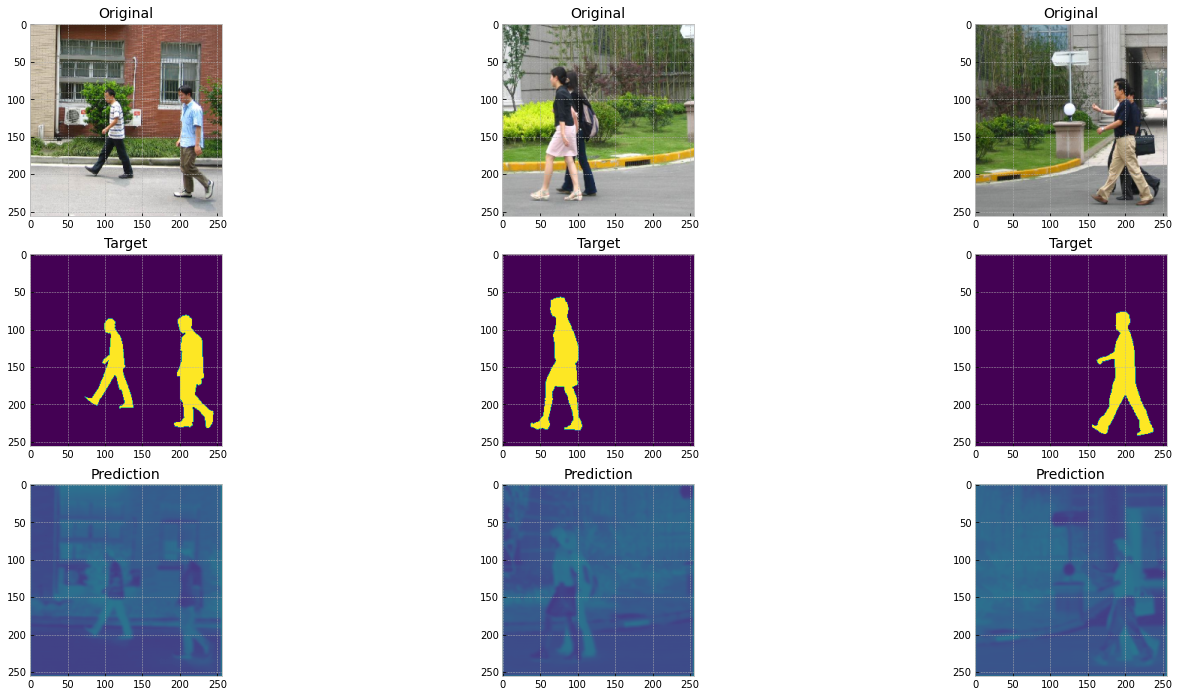

In [5]:
from pathlib import Path

import torch
from apppath import ensure_existence
from draugr.numpy_utilities import chw_to_hwc, SplitEnum
from draugr.opencv_utilities import cv2_resize
from draugr.random_utilities import seed_stack

from draugr.torch_utilities import (
    TorchCacheSession,
    TorchDeviceSession,
    TorchEvalSession,
    global_torch_device,
)
from matplotlib import pyplot

pyplot.style.use("bmh")

from torch.utils.data import DataLoader
from tqdm import tqdm

from neodroidvision import PROJECT_APP_PATH
from neodroidvision.data.segmentation import PennFudanDataset
from neodroidvision.multitask import SkipHourglassFission

In [ ]:
def main(
    base_path: Path = Path.home() / "Data" / "Datasets" / "PennFudanPed",
    train_model: bool = False,
):
    """ """

    # base_path = Path("/") / "encrypted_disk" / "heider" / "Data" / "PennFudanPed"

    save_model_path = (
        ensure_existence(PROJECT_APP_PATH.user_data / "models")
        / "penn_fudan_ped_seg.model"
    )

    eval_model = not train_model
    SEED = 87539842
    batch_size = 8
    num_workers = 0
    encoding_depth = 3
    seed_stack(SEED)

    train_set = PennFudanDataset(base_path, SplitEnum.training)

    valid_loader = DataLoader(
        PennFudanDataset(base_path, SplitEnum.validation),
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
    )

    model = SkipHourglassFission(
        input_channels=train_set.predictor_shape[-1],
        output_heads=(train_set.response_shape[-1],),
        encoding_depth=encoding_depth,
    )
    model.to(global_torch_device())

    if eval_model:
        if save_model_path.exists():
            model.load_state_dict(torch.load(str(save_model_path)))
            print("loading saved model")

        with TorchDeviceSession(global_torch_device("cpu"), model):
            with torch.no_grad():
                with TorchCacheSession():
                    with TorchEvalSession(model):
                        valid_masks = []
                        out_data = []
                        a = (256, 256)
                        tr = min(len(valid_loader.dataset) * 4, 2000)
                        probabilities = []
                        for sample_i, (data, target) in enumerate(tqdm(valid_loader)):
                            data = data.to(global_torch_device())
                            outpu, *_ = model(data)
                            for m, d, p in zip(
                                target.cpu().detach().numpy(),
                                data.cpu().detach().numpy(),
                                torch.sigmoid(outpu).cpu().detach().numpy(),
                            ):
                                out_data.append(cv2_resize(chw_to_hwc(d), a))
                                valid_masks.append(cv2_resize(m[0], a))
                                probabilities.append(cv2_resize(p[0], a))
                                sample_i += 1

                                if sample_i >= tr - 1:
                                    break

                            if sample_i >= tr - 1:
                                break

                        min_a = min(3, len(out_data))
                        f, ax = pyplot.subplots(min_a, 3, figsize=(24, 12))

                        for i in range(min_a):
                            ax[0, i].imshow(out_data[i], vmin=0, vmax=1)
                            ax[0, i].set_title("Original", fontsize=14)

                            ax[1, i].imshow(valid_masks[i], vmin=0, vmax=1)
                            ax[1, i].set_title("Target", fontsize=14)

                            ax[2, i].imshow(probabilities[i], vmin=0, vmax=1)
                            ax[2, i].set_title("Prediction", fontsize=14)

                        pyplot.show()


if __name__ == "__main__":
    main(train_model=False)